In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import seaborn as sns
from pylab import rcParams
from collections import defaultdict

In [2]:
# load data sets
os.chdir('/home/roman/Documents/Projects/Bubbles')
dataset_original = '^GSPC.csv'
dataset_name = 'S&P 500'
data_original = pd.read_csv(dataset_original, index_col = 'Date')
data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
data_norm = data_original['Close'] / data_original['Close'][-1]
data_ch = data_original['Close'].pct_change()
window = 10
data_vol = data_original['Close'].pct_change().rolling(window).std()
data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
data.columns = ['price', 'norm', 'ch', 'vol']

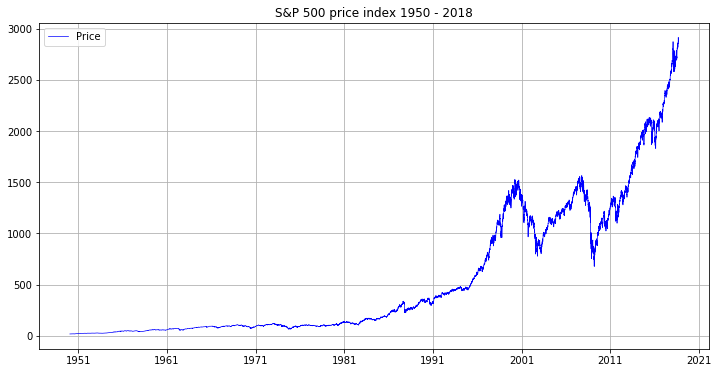

In [3]:
# Plot price over time
rcParams['figure.figsize'] = 12, 6
plt.plot(data['price'], color='blue', linewidth=0.7)
plt.grid()
plt.legend(['Price'])
plt.title('S&P 500 price index 1950 - 2018')
plt.show()

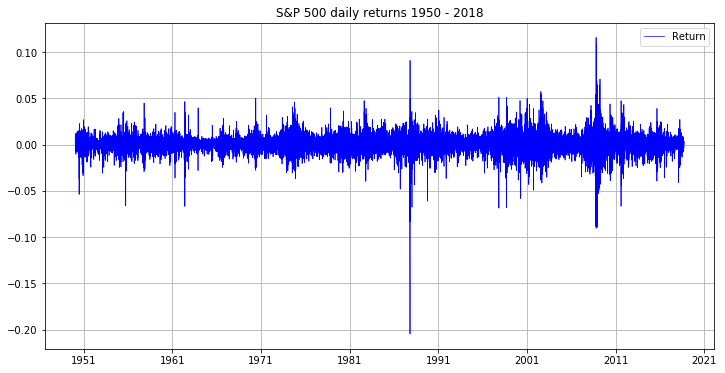

In [5]:
# Plot return over time
plt.plot(data['ch'], color='blue', linewidth=0.7)
plt.grid()
plt.legend(['Return'])
plt.title('S&P 500 daily returns 1950 - 2018')
plt.show()

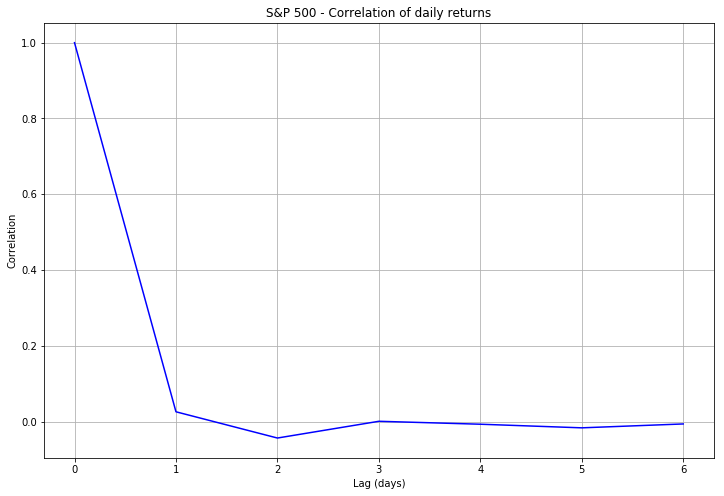

In [12]:
# Correlation
corr = [1]
for i in range(1, 7):
    corr.append(np.corrcoef(data['ch'][i:], data['ch'][:-i])[0, 1])
plt.plot(corr, color='blue')
plt.title('S&P 500 - Correlation of daily returns')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.grid()

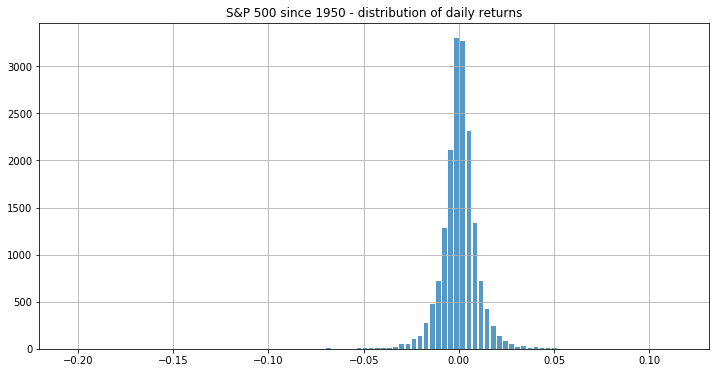

In [8]:
# Plot distribution of daily returns
plt.hist(data['ch'], bins=100, rwidth=0.75, alpha=0.75)
plt.title('S&P 500 since 1950 - distribution of daily returns')
plt.grid()
plt.show()

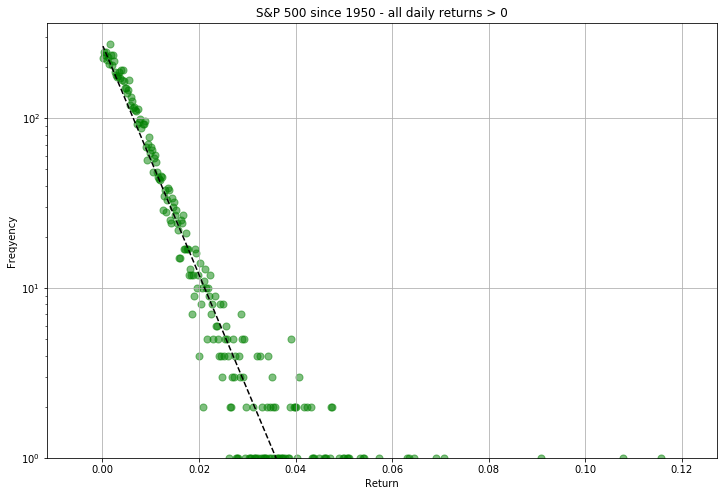

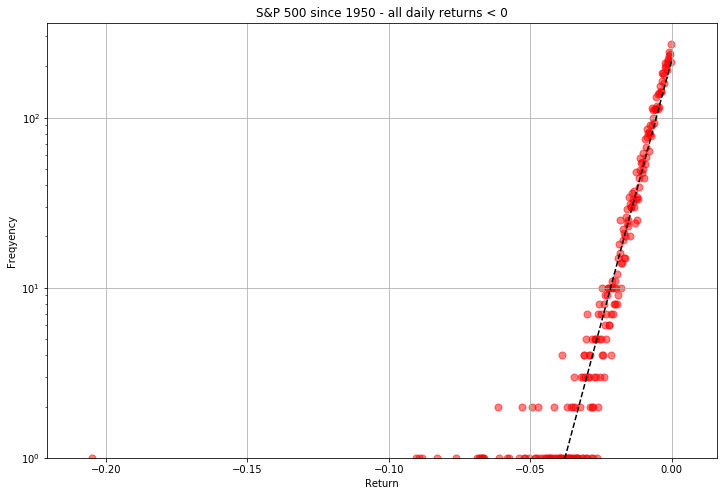

In [23]:
# Plot log-distribution of daily returns
max_return = max(abs(data['ch']))
m = round(max_return+0.01,2)
bins = np.linspace(-m, m, 2000)
d = {}
for i in range(1, len(bins)+1):
    d[i] = bins[i-1]
disc = np.digitize(x=data['ch'], bins=bins)
d1 = defaultdict(int)
for i in disc:
    d1[d[i]] += 1
rcParams['figure.figsize'] = 12, 8
df = pd.DataFrame(list(d1.items()))
df.columns = ['return', 'n']
df_pos = df[df['return']>0]
df_pos = df_pos.sort_values(by='return', ascending=False).reset_index(drop=True)
plt.scatter(df_pos['return'], df_pos['n'], s=50, color='green', alpha=0.5)
plt.yscale('log')
df_pos_reg = df_pos[df_pos['return']<0.04]
m, c = np.polyfit(df_pos_reg['return'], np.log(df_pos_reg['n']), 1)
y_fit = np.exp(m*df_pos['return'] + c)
plt.ylim(bottom=10**0)
plt.plot(df_pos['return'], y_fit, color='black', ls='dashed')
plt.title('S&P 500 since 1950 - all daily returns > 0')
plt.xlabel('Return')
plt.ylabel('Freqyency')
plt.grid()
plt.show()

df_neg = df[df['return']<0]
df_neg = df_neg.sort_values(by='return', ascending=True).reset_index(drop=True)
plt.scatter(df_neg['return'], df_neg['n'], s=50, color='red', alpha=0.5)
plt.yscale('log')
df_neg_reg = df_neg[df_neg['return']>-0.045]
m, c = np.polyfit(df_neg_reg['return'], np.log(df_neg_reg['n']), 1)
y_fit = np.exp(m*df_neg['return'] + c)
plt.ylim(bottom=10**0)
plt.plot(df_neg['return'], y_fit, color='black', ls='dashed')
plt.title('S&P 500 since 1950 - all daily returns < 0')
plt.xlabel('Return')
plt.ylabel('Freqyency')
plt.grid()
plt.show()

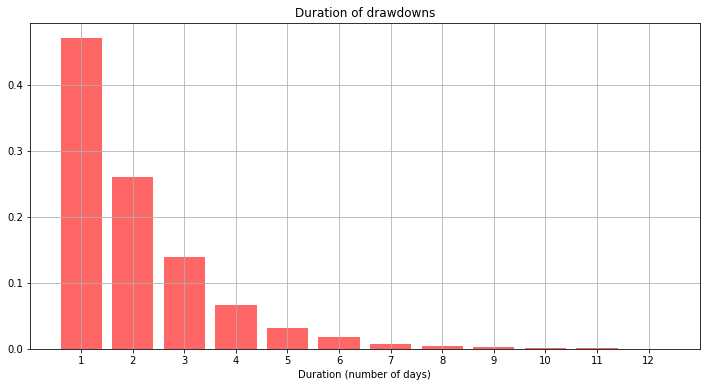

In [18]:
# Drawdowns
pmin_pmax = (data['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
pmax = pmin_pmax[pmin_pmax == 1]
pmin = pmin_pmax[pmin_pmax == -1]
# make sure drawdowns start with pmax, end with pmin:
if pmin.index[0] < pmax.index[0]:
    pmin = pmin.drop(pmin.index[0])
if pmin.index[-1] < pmax.index[-1]:
    pmax = pmax.drop(pmax.index[-1])
dd = (np.array(data['price'][pmin.index]) - np.array(data['price'][pmax.index])) \
    / np.array(data['price'][pmax.index])
dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
     'duration': dur}    
df_d = pd.DataFrame(d).set_index('Date')
df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
df_d = df_d.sort_values(by='drawdown')
df_d['rank'] = list(range(1,df_d.shape[0]+1))

max_dd = max(abs(df_d['drawdown']))
m = round(max_dd+0.01,2)
bins = np.linspace(-m, m, 800)
d = {}
for i in range(1, len(bins)+1):
    d[i] = bins[i-1]
disc = np.digitize(x=df_d['drawdown'], bins=bins)
d1 = defaultdict(int)
for i in disc:
    d1[d[i]] += 1

rcParams['figure.figsize'] = 12, 6
plt.bar(x=df_d['duration'].value_counts().index, height=df_d['duration'].\
        value_counts()/df_d['duration'].shape[0], color='red', alpha=0.6)
plt.xticks(df_d['duration'].value_counts().index)
plt.title('Duration of drawdowns')
plt.xlabel('Duration (number of days)')
plt.grid()
plt.show()

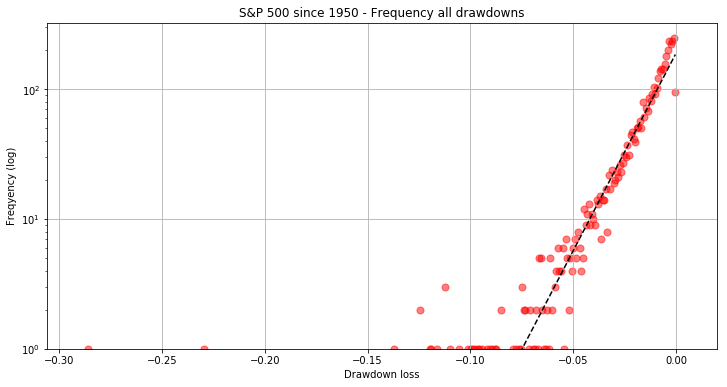

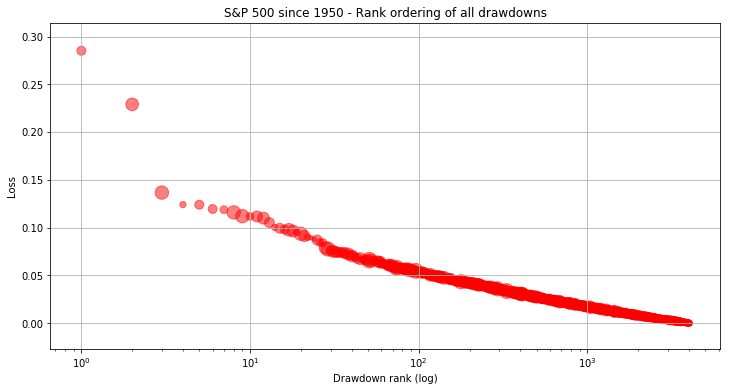

In [22]:
rcParams['figure.figsize'] = 12, 6
df_d_bins = pd.DataFrame(list(d1.items()))
df_d_bins.columns = ['drawdown', 'n']
plt.scatter(df_d_bins['drawdown'], df_d_bins['n'], s=50, alpha=0.5, color='red')
plt.yscale('log')
df_d_bins_reg = df_d_bins[df_d_bins['drawdown']>-0.08]
m, c = np.polyfit(df_d_bins_reg['drawdown'], np.log(df_d_bins_reg['n']), 1)
y_fit = np.exp(m*df_d_bins['drawdown'] + c)
plt.ylim(bottom=10**0)
plt.plot(df_d_bins['drawdown'], y_fit, color='black', ls='dashed')
plt.title('S&P 500 since 1950 - Frequency all drawdowns')
plt.xlabel('Drawdown loss')
plt.ylabel('Freqyency (log)')
plt.grid()
plt.show()

plt.scatter(df_d['rank'], abs(df_d['drawdown']), s=20*df_d['duration'], alpha=0.5,\
            color='red')
plt.xscale('log')
plt.title('S&P 500 since 1950 - Rank ordering of all drawdowns')
plt.xlabel('Drawdown rank (log)')
plt.ylabel('Loss')
plt.grid()
plt.show()
